# **프로젝트 : CAM을 만들고 평가해보자**

## **Google Mount**
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

os.chdir('/content/drive/MyDrive/AIFFEL/GoingDeeper/GD10')

In [3]:
pwd

'/content/drive/MyDrive/AIFFEL/GoingDeeper/GD10'

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<br>

## **데이터 준비하기**
---

In [6]:
# 최초 수행시에는 다운로드가 진행된다. 
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteHAHMS1/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteHAHMS1/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


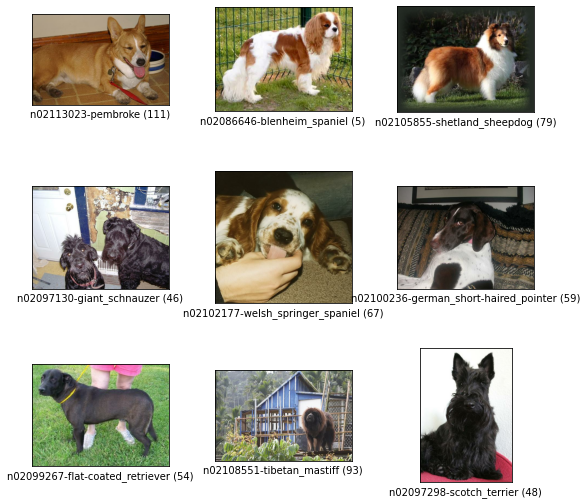

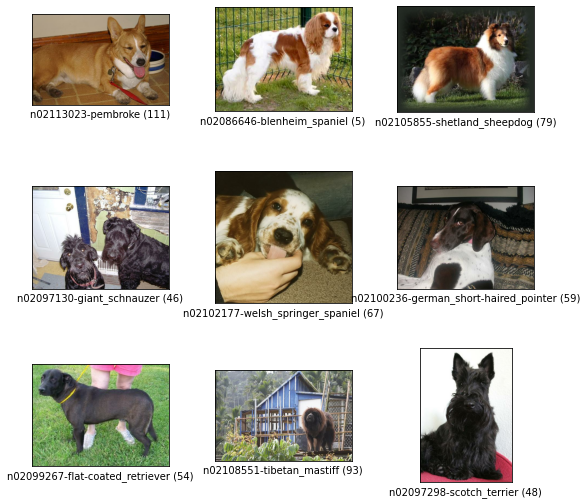

In [7]:
tfds.show_examples(ds_train, ds_info)

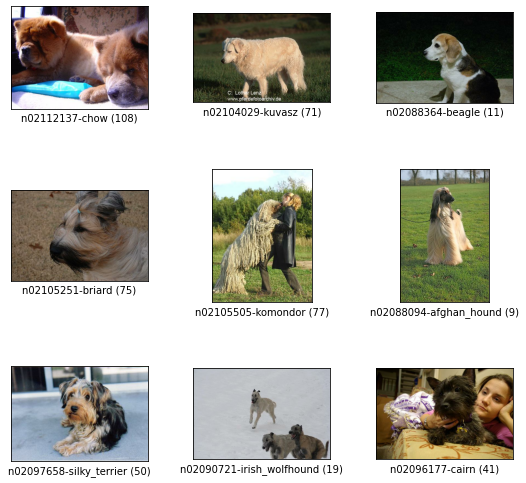

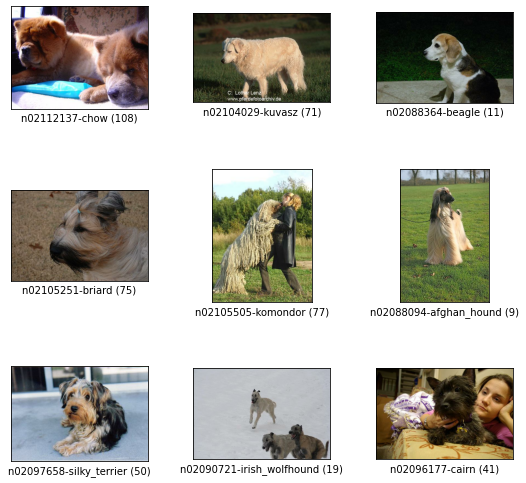

In [8]:
tfds.show_examples(ds_test, ds_info)

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

<br>

---

- tensorflow의 tfds의 경우 ds_info의 bbox는 height를 첫번째 axis로 삼고있다.<br><br>
    - [ymin, xmin, ymax, xmax]

- 'stanford_dogs` 데이터셋에는 총 120개의 견종이 있다.

---

<br><br>

In [10]:
num_classes = ds_info.features['label'].num_classes
num_classes

120

<br>
<br>

## **CAM, Grad-CAM에 사용할 모델 만들기**
---

In [15]:
# CAM 모델의 구조를 채워보자 
# ResNet50을 백본 네트워크로 이용한다.

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,   # Imagenet 분류기 fully connected layer 제거
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    pooling='avg',   # GAP를 적용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs=base_model.input, outputs=preds)

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

<br>

## **데이터 준비(전처리, train/test data 분리, batch_size 설정)**
---

- 학습데이터와 검증데이터에 normalizing과 resizing을 포함한 간단한 전처리를 `normalizae_and_resize_img()`에서 수행하며, 이를 포함하여 `apply_normalize_on_dataset()`에서 배치를 구성한다.

In [17]:
def normalize_and_resize_img(input):
    # Normalizes images : `uint8` >> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls = 2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [18]:
# 데이터셋에 전처리와 배치처리를 적용한다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 보자
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [19]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

In [21]:
history_model = model.fit(
    ds_train_norm,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16), 
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs=10,
    validation_data = ds_test_norm,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/10
750/750 [==============================] - 97s 125ms/step - loss: 4.5380 - accuracy: 0.0262 - val_loss: 4.8685 - val_accuracy: 0.0203
Epoch 2/10
750/750 [==============================] - 93s 124ms/step - loss: 4.1754 - accuracy: 0.0533 - val_loss: 4.9170 - val_accuracy: 0.0415
Epoch 3/10
750/750 [==============================] - 94s 125ms/step - loss: 3.7563 - accuracy: 0.0939 - val_loss: 3.9075 - val_accuracy: 0.0976
Epoch 4/10
750/750 [==============================] - 93s 124ms/step - loss: 3.3450 - accuracy: 0.1620 - val_loss: 3.7735 - val_accuracy: 0.1106
Epoch 5/10
750/750 [==============================] - 93s 124ms/step - loss: 2.8667 - accuracy: 0.2451 - val_loss: 4.9806 - val_accuracy: 0.0721
Epoch 6/10
750/750 [==============================] - 92s 123ms/step - loss: 2.4430 - accuracy: 0.3327 - val_loss: 3.2624 - val_accuracy: 0.2085
Epoch 7/10
750/750 [==============================] - 93s 124ms/step - loss: 1.9589 - accuracy: 0.4433 - val_loss: 3.4187 - val_ac

<br>

***학습시킨 가중치를 저장해보자***

<br>

In [22]:
import os

model_path = os.getcwd() + '/model1.h5'
model.save(model_path)
print('저장 완료!')

저장 완료!


<br><br>

## **CAM 구현하기**
---

<br>

***CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, `get_one()` 함수로 데이터셋에서 한 장씩 뽑을 수 있또록 했다.***

In [91]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # 학습한 모델에서 원하는 layer의 output을 얻기 위해서 모델의 input과 output을 정의해준다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor,0))
    conv_outputs = conv_outputs[0, :, :, :]  # 7 x 7 x 2048 피쳐맵

    # 모델의 weight activation은 마지막 layer에 있다.
    class_weights = model.layers[-1].get_weights()[0]  # (2,048, 120)
    # get_weights는 densce 레이어에만 사용할 수 있는듯? 
    # get_weights()[0] 번 인덱스는 입력 weight matrix를
    # get_weights()[1] 번 인덱스는 출력 weight matrix를 의미한다.

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])  # 7 x 7 이미지
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타난다.
        cam_image += w*conv_outputs[:,:,i]

    cam_image /= np.max(cam_image)  # activation score를 normalize한다. 
    # 여기서 np.max는 행렬의 최대값 한개를 반환한다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize한다.
    return cam_image

In [23]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


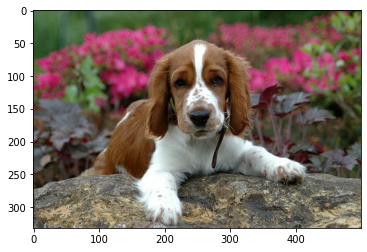

In [58]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

<br>

**CAM을 시각화해보자**

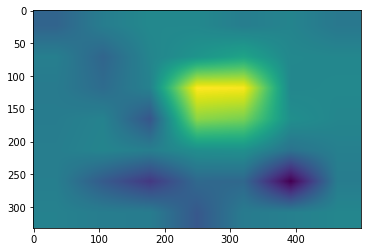

In [60]:
cam_image = generate_cam(model, item)
plt.imshow(cam_image)
plt.show()

<br>

**CAM이미지를 원본 이미지와 합쳐보자**

In [61]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

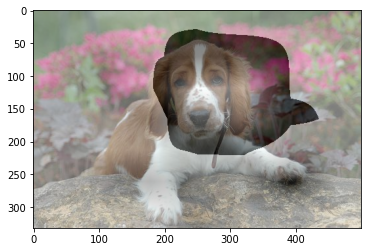

In [62]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

<br><br>

## **Grad-CAM 구현하기**
---

80


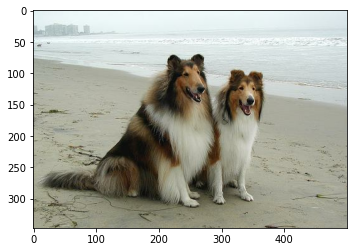

In [34]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

- 이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 `activation_layer`를 뽑아서 쓸 수 있도록 `activation_layer`의 이름을 받고 이를 활용해야 한다.

In [35]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.

    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output[0].shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


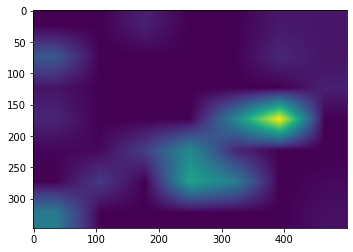

In [36]:
grad_cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

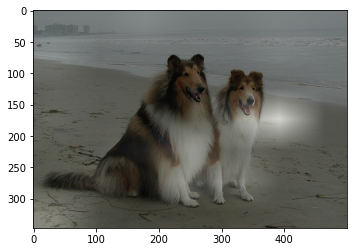

In [37]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

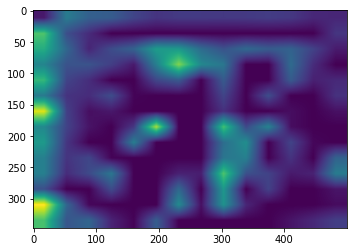

In [38]:
grad_cam_image = generate_grad_cam(model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

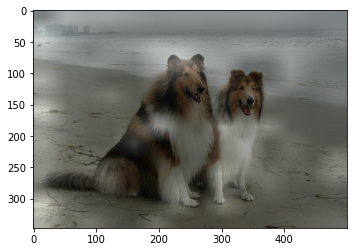

In [39]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

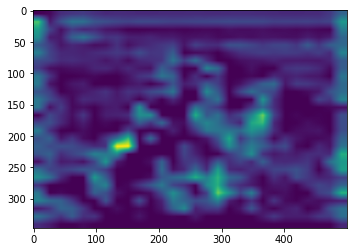

In [40]:
grad_cam_image = generate_grad_cam(model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

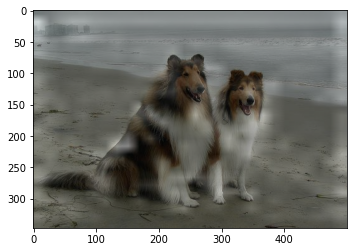

In [41]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

<br><br>

## **Detection with CAM - 바운딩 박스 구하기**

### **CAM을 통해 바운딩박스 구하기**
---

67


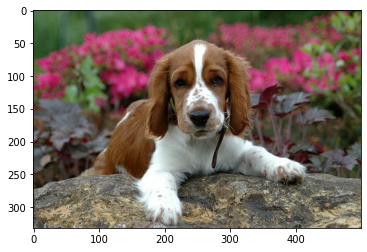

In [179]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

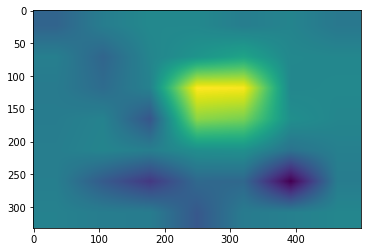

In [180]:
cam_image = generate_cam(model, item)
plt.imshow(cam_image)
plt.show()

In [181]:
def visualize_cam_on_image(src1, src2, alpha=0.9):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

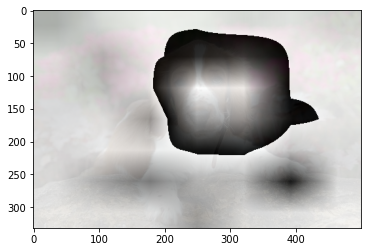

In [182]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [183]:
def visualize_cam_on_image(src1, src2, alpha=0.3):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

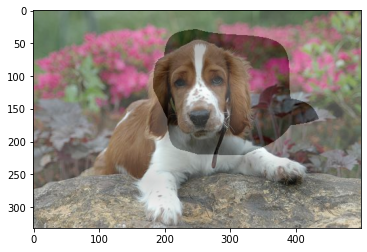

In [184]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

- 아래의 `get_bbox()`의 함수는 바운딩 박스를 만들기 위해 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앤다. 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾는다. 


- 이때, `rotated_rect`라는 회전된 바운딩 박스를 얻을 수 있다. 
- `boxPoints()`로 이를 꼭지점으로 바꾸어준다. 마지막에는 `int`자료형으로 변환한다.

In [195]:
cam_image.shape

(332, 500)

In [206]:
print(np.max(cam_image))
print(np.min(cam_image))
print(np.mean(cam_image))

0.9984866
-0.9045458
-0.050075818


In [197]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indices = cam_image <= score_thresh
    cam_image[low_indices] = 0
    cam_image = (cam_image*255).astype(np.uint8)

    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [262]:
cam_image = generate_cam(model, item)

In [263]:
rect = get_bbox(cam_image, score_thresh=0.001)
rect

array([[153,  70],
       [347, -15],
       [430, 171],
       [236, 257]])

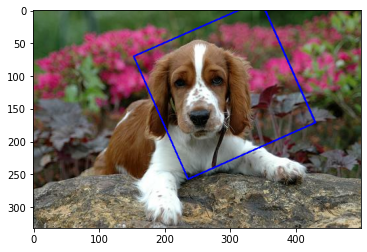

In [264]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

---

In [265]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [266]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.045180722891566265, 0.306, 0.7740963855421686, 0.86]

In [267]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [268]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [269]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.4733605605925266

<br>

## **결론 및 회고**

- 이번 프로젝트에서는 explainable network 중 하나인 cnn layer의 출력 즉, activate 되고 나서 모델이 이미지의 어떤 특징을 중점으로 보고 있는지를 확인할 수 있는 Class Activation Map을 직접 구해보고 시각화를 해보았다.

- 처음 CAM이 발표되었을때는 최종 출력 레이어에서의 cam 이미지만 출력할 수 있었지만 이후 Gradient를 기반으로 cam을 출력할 수 있도록 새로운 방법이 제시되었는데 grad-cam이다. 

- cam과 grad-cam을 직적 구현해보고 시각화를 진행해보았다. 또한 결과를 기반으로 바운딩박스를 추가 구현해보았다. 

- 실제 바운딩박스와의 정량적인 비교는 IOU를 통해 비교해보았고 결과는 조금 미흡하였다.